In [47]:
import numpy as np
import pandas as pd
from sklearn import svm, model_selection, preprocessing, pipeline, impute, feature_selection
from sklearn.experimental import enable_iterative_imputer
from itertools import chain, combinations, product
import math
import time

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)


import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

%matplotlib inline
from pyAgrum.lib.bn2roc import showROC
from pyAgrum.lib.bn2roc import showPR
from pyAgrum.lib.bn2roc import showROC_PR

import networkx as nx
import graphviz

In [48]:
# Constants
EPSILON = 0.001

In [49]:
data = pd.read_csv("insurance.csv")
data

,GoodStudent,Age,SocioEcon,RiskAversion,VehicleYear,ThisCarDam,RuggedAuto,Accident,MakeModel,DrivQuality,...,HomeBase,AntiTheft,PropCost,OtherCarCost,OtherCar,MedCost,Cushioning,Airbag,ILiCost,DrivHist
0,False,Adult,Prole,Adventurous,Older,Moderate,EggShell,Mild,Economy,Poor,...,City,False,TenThou,Thousand,True,Thousand,Poor,False,Thousand,Many
1,False,Senior,Prole,Cautious,Current,None,Football,None,Economy,Normal,...,City,True,Thousand,Thousand,True,Thousand,Good,True,Thousand,Zero
2,False,Senior,UpperMiddle,Psychopath,Current,None,Football,None,FamilySedan,Excellent,...,City,False,Thousand,Thousand,False,Thousand,Good,True,Thousand,One
3,False,Adolescent,Middle,Normal,Older,None,EggShell,None,Economy,Normal,...,Suburb,False,Thousand,Thousand,True,Thousand,Fair,False,Thousand,Zero
4,False,Adolescent,Prole,Normal,Older,Moderate,Football,Moderate,Economy,Poor,...,City,False,TenThou,Thousand,False,Thousand,Fair,False,Thousand,Many
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,False,Adult,Prole,Adventurous,Older,Mild,Football,Mild,Economy,Poor,...,City,False,Thousand,Thousand,True,Thousand,Fair,False,Thousand,Many
19996,False,Adult,Middle,Normal,Older,None,Tank,None,FamilySedan,Normal,...,Suburb,False,Thousand,Thousand,True,Thousand,Good,False,Thousand,Zero
19997,False,Senior,UpperMiddle,Normal,Current,None,Football,None,Luxury,Excellent,...,Secure,True,TenThou,Thousand,False,Thousand,Excellent,True,Thousand,Zero
19998,False,Adult,Middle,Normal,Older,None,Football,None,FamilySedan,Excellent,...,Suburb,False,Thousand,Thousand,True,Thousand,Good,True,Thousand,Zero


In [50]:
#X = data[data.columns.drop(["RiskAversion", "Accident"])]
#y = data[["RiskAversion", "Accident"]]

X = data[data.columns.drop("Accident")]
y = data["Accident"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [51]:
app = X_train.copy()
app["Accident"] = y_train

learner=gum.BNLearner(app)

bn = learner.learnBN()

bn=learner.useGreedyHillClimbing().useScoreK2().learnBN()


In [7]:
gnb.flow.add(gnb.getBN(bn,size="20"))
gnb.flow.display()

In [8]:
acc = 0
domain = sorted(np.unique(y_train.to_numpy()))
for i in X_test.index :
    ie=gum.LazyPropagation(bn)
    ie.addTarget("Accident")
    instance = X_test.loc[i]
    for j in X_test.columns :
        ie.addEvidence(j,str(instance[j]))
    ie.makeInference()
    post = ie.posterior("Accident")
    #print(post)
    #print(y_test.loc[i])
    acc = acc + post[domain.index(y_test.loc[i])]
print(acc / len(X_test.index))

0.9258632992338628


In [9]:
bn.dag().dSeparation(bn.nodeset(["DrivHist"]),bn.nodeset(["CarValue"]),bn.nodeset(["DrivingSkill", "RiskAversion"]))

True

In [10]:
bn.nodeset(["OtherCarCost"])

<Swig Object of type 'gum::NodeSet *' at 0x7f5f05c99210>

In [11]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
ie.setEvidence({"RiskAversion" : "Psychopath", "Accident" : "None"})
ie.evidenceProbability()
#print(ie.posterior(bn.idFromName("Accident")))


0.008239443739406578

In [12]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
ie.addJointTarget(set(["Accident", "RiskAversion"]))
#ie.setEvidence({"RiskAversion" : "Psychopath"})
#ie.evidenceProbability()
print(ie.jointPosterior(set(["Accident", "RiskAversion"])))


      ||  Accident                             |
RiskAv||Mild     |Moderate |None     |Severe   |
------||---------|---------|---------|---------|
Advent|| 0.0314  | 0.0282  | 0.1592  | 0.0431  |
Cautio|| 0.0153  | 0.0129  | 0.1927  | 0.0184  |
Normal|| 0.0401  | 0.0347  | 0.3581  | 0.0510  |
Psycho|| 0.0020  | 0.0018  | 0.0082  | 0.0028  |



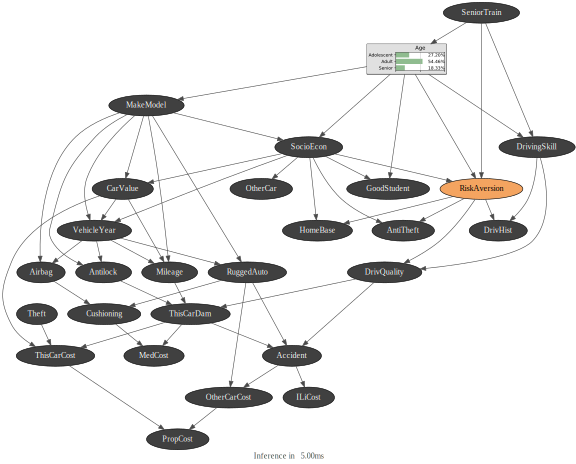

In [13]:
res = gnb.showInference(model = bn, engine = gum.LazyPropagation(bn), evs = {"RiskAversion" : "Psychopath"}, targets = ["Age"], view = "graph")


In [14]:
#bn.cpt(1).variable(1).domain()

bn.variableFromName("Age").labels()

('Adolescent', 'Adult', 'Senior')

In [15]:
ie=gum.LazyPropagation(bn)
#ie.makeInference()
ie.addEvidence("RiskAversion","Cautious")
ie.addJointTarget(set(["Accident", "ILiCost"]))
print(ie.jointPosterior(set(["Accident", "ILiCost"])))


      ||  Accident                             |
ILiCos||Mild     |Moderate |None     |Severe   |
------||---------|---------|---------|---------|
Hundre|| 0.0000  | 0.0018  | 0.0001  | 0.0044  |
Millio|| 0.0000  | 0.0012  | 0.0001  | 0.0039  |
TenTho|| 0.0001  | 0.0030  | 0.0001  | 0.0076  |
Thousa|| 0.0636  | 0.0478  | 0.8052  | 0.0611  |



In [16]:
l = np.unique(y_train.to_numpy())
print(sorted(l))

['Mild', 'Moderate', 'None', 'Severe']


In [17]:
def powerset(iterable,depth = np.inf):
    s = list(iterable)
    tmp = list(chain.from_iterable(combinations(s, r) for r in range(min(len(s),depth)+1)))
    return tmp

In [18]:
def omega(variable, data) :
    return list(data[variable].unique())

In [19]:
omega("Age",X)

['Adult', 'Senior', 'Adolescent']

In [20]:
def reduce_dataset(instance, X,y) :
    print(instance)
    columns = list(X.columns)
    #columns.remove("index")
    for i,value in enumerate(instance) :
        if isinstance(value, str) or not math.isnan(value) :
            print(columns[i], " is evidence!")
            X = X[X[columns[i]] == value]
            X = X.drop(columns[i], axis=1)
        else :
            print(columns[i], " is unobserved")
    y = y[[j for j in y.index if j in X.index]]
    return X,y

In [21]:
def list_diff(list1, list2) :
    diff = []
    for i in list1 :
        if i not in list2 :
            diff.append(i)
    return diff

def prune_network(bn, ev_vars, hyp_vars, supp_vars = None) :
    #IMPORTANT: Hard copy of the bn
    bn_pr = gum.BayesNet(bn)
    # Find supplementary nodes of a network if not given
    
    if supp_vars is None :
        supp_vars = []
        for i in bn_pr.names() :
            if not i in ev_vars and not i in hyp_vars :
                supp_vars.append(i)
    # Delete from the network the nodes that are conditionally independent from the hypothesis variables (target) given the evidence
    dsep_nodes = []
    for i in supp_vars :
        if bn_pr.dag().dSeparation(bn_pr.nodeset([i]),bn_pr.nodeset(hyp_vars),bn_pr.nodeset(ev_vars)):
            dsep_nodes.append(i)
            bn_pr.erase(i)
    return bn_pr, dsep_nodes

def map_query(bn, ev_vars, hyp_vars) :
    return propagate_evidence(bn, ev_vars, joint_targets = [hyp_vars]).jointPosterior(set(hyp_vars))


def propagate_evidence(bn, ev_vars, joint_targets = []) :
    ie=gum.LazyPropagation(bn)
    for i in joint_targets :
        ie.addJointTarget(set(i))
    ie.setEvidence(ev_vars)
    ie.makeInference()
    return ie
            
    
def omega(variables, data = None , bn = None) :
    domains = []
    if bn is not None :
        for variable in variables :
            domains.append(sorted(bn.variableFromName(variable).labels()))
    else :
        for variable in variables :
            domains.append(sorted(data[variable].unique()))
    return [p for p in product(*domains)]
    

def prepare_mapi(instances, variables) :
     #Type checking
    if isinstance(instances, pd.core.frame.DataFrame) :
        instances = instances.to_numpy()
    #Array for each instance
    evidence_set = []
    # For each instance:
    for instance in instances :
        # Check which are the evidence variables
        evidence = dict()
        for i,value in enumerate(instance) :
            if isinstance(value, str) or not math.isnan(value) :
                evidence[variables[i]] = value
        evidence_set.append(evidence)
    return evidence_set
    

# True if R is relevant/MAP-dependent
# False if R is irrelevant/MAP-independent
def map_dependence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = None, hyp_posterior = None, return_jsd = False) : 
    # Check which are the supplementary (missing) variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
    # Check if R in unobserved
    #print(supp_vars)
    for R in set_R :
        if R not in supp_vars :
            raise Exception("The variable", R, "is in the set R but is not a supplementary node")
    y = hyp_vars_assign
    posterior = hyp_posterior
    if y is None :    
        # Perform a MAP-query and get the argmax from the posterior. 
        # Check if a posterior for P(H|e) was provided
        if hyp_posterior is None :
            posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
            y = posterior.argmax()[0][0]
        else :
            y = posterior.argmax()[0][0]
    # Obtain domain of R
    omega_R = omega(set_R, bn = bn)
    # For each value assignment r in omega(R)
    jsd = 0
    for value_assignment_r in omega_R :
        # Fill in values
        ev_vars_alt = ev_vars.copy()
        for i,value in enumerate(value_assignment_r) :
            ev_vars_alt[set_R[i]] = value
        #print(instance)
        #print(instance_alt)
        # Inference with evidence and r
        posterior_alt = map_query(bn, ev_vars = ev_vars_alt, hyp_vars = hyp_vars)
        y_alt = posterior_alt.argmax()[0][0]
        # Check if we need to compute the jsd divergence between P(H|e) and P(H|e,r)
        if return_jsd :
            jsd = max(jsd, JSD(posterior,posterior_alt))
        # Comparar con prediccion de instance
        #print(value_assignment_r)
        #print(y, " == ", y_alt)
        #print(posterior.argmax()[1], "--", posterior_alt.argmax()[1])
        if y != y_alt :
            if return_jsd :
                return True, jsd
            else :
                return True
    if return_jsd:
        return False, jsd
    else :
        return False
    
def map_independence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = None, hyp_posterior = None, return_jsd = False) : 
    if return_jsd :
        mapd, jsd = map_dependence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = hyp_vars_assign,
                                   hyp_posterior = hyp_posterior, return_jsd = True)
        return (not mapd, jsd)
    else :
        return not map_dependence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = hyp_vars_assign,
                                  hyp_posterior = hyp_posterior, return_jsd = False)

In [22]:
bn.dag().dSeparation(bn.nodeset(["DrivHist"]),bn.nodeset(["CarValue"]),bn.nodeset(["DrivingSkill", "RiskAversion"]))
bn_pr = prune_network(bn, ["DrivingSkill", "RiskAversion"], ["DrivHist"])
#bn_pr.names()

swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python dete

In [23]:
map_query(bn, ev_vars = {'RiskAversion':"Psychopath"}, hyp_vars = ["Accident"]).argmax()[0][0]

{'Accident': 2}

In [24]:
map_independence(bn, ["ILiCost"], {'RiskAversion':"Psychopath"}, ["Accident"])

False

In [25]:
omega(["RiskAversion", "DrivingSkill"], bn = bn)

[('Adventurous', 'Expert'),
 ('Adventurous', 'Normal'),
 ('Adventurous', 'SubStandard'),
 ('Cautious', 'Expert'),
 ('Cautious', 'Normal'),
 ('Cautious', 'SubStandard'),
 ('Normal', 'Expert'),
 ('Normal', 'Normal'),
 ('Normal', 'SubStandard'),
 ('Psychopath', 'Expert'),
 ('Psychopath', 'Normal'),
 ('Psychopath', 'SubStandard')]

In [26]:
def check_every_r_bn(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_by_ev = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_by_ev)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_by_ev :
            supp_vars.append(i)
    
    S = powerset(supp_vars,depth = depth)
    S.pop(0)
    # Divide by length
    S_split = []
    size = 0
    for i in S :
        if len(i) != size:
            size = size + 1
            S_split.append([])
        S_split[-1].append(i)
        
    # Variables to store relevant/irrelevant sets
    relevant_sets = []
    irrelevant_sets = []
    
    # Get the posterior and the argmax from the original MAP-query
    posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    for i in range(0,len(S_split)) :
        for j in S_split[i] :
            # If relevant
            print(list(j))
            if map_dependence(bn_pr, set_R = list(j), ev_vars = ev_vars, hyp_vars = hyp_vars, hyp_vars_assign=y) :
                relevant_sets.append(j)
                # Apply prune
                for k in range(i+1,len(S_split)) :
                    tmp = []
                    for l in S_split[k] :
                        if set(j).issubset(set(l)) :
                            relevant_sets.append(l)
                        else :
                            tmp.append(l)
                    S_split[k] = tmp
            # If irrelevant
            else :
                irrelevant_sets.append(j)
    return relevant_sets, irrelevant_sets, dsep_by_ev

In [27]:
def get_c_exp(bn, ev_vars, hyp_vars, hyp_vars_assign = None) : 
    print(hyp_vars_assign)
    if hyp_vars_assign is None :
        posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
        hyp_vars_assign = posterior.argmax()[0][0]
    
    # Alternative. First compute P(H|e) and then P(e) and compute the product
    ie=gum.LazyPropagation(bn)
    ie.addJointTarget(set(hyp_vars))
    ie.setEvidence(ev_vars)
    ie.makeInference()
    post = ie.jointPosterior(set(hyp_vars))

    # Compute P(e)
    ie=gum.LazyPropagation(bn)
    ie.setEvidence(ev_vars)
    ie.makeInference()
    p_e = ie.evidenceProbability()
    
    post = post * p_e
    inst = gum.Instantiation(post)
    inst.fromdict(hyp_vars_assign)
    P_eh = post.get(inst)
    return post/P_eh

def decomposition_prune(relevant_set, S_split, relevant_sets) :
    i = len(relevant_set)
    for k in range(i,len(S_split)) :
        tmp = []
        for l in S_split[k] :
            if set(relevant_set).issubset(set(l)) :
                relevant_sets.append(l)
            else :
                tmp.append(l)
        S_split[k] = tmp
    return S_split, relevant_sets

def conditional_independence_prune(irrelevant_set, S_split, irrelevant_sets) :
    #IMPORTANT: Hard copy of the bn
    bn_pr = gum.BayesNet(bn)
    # Find supplementary nodes of a network if not given
    
    if supp_vars is None :
        supp_vars = []
        for i in bn_pr.names() :
            if not i in ev_vars and not i in hyp_vars :
                supp_vars.append(i)
    # Delete from the network the nodes that are conditionally independent from the hypothesis variables (target) given the evidence
    dsep_nodes = []
    for i in supp_vars :
        if bn_pr.dag().dSeparation(bn_pr.nodeset([i]),bn_pr.nodeset(hyp_vars),bn_pr.nodeset(ev_vars)):
            dsep_nodes.append(i)
            bn_pr.erase(i)
    return bn_pr, dsep_nodes

def check_every_r_silja(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_by_ev = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_by_ev)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_by_ev :
            supp_vars.append(i)
    
    S = powerset(supp_vars,depth=depth)
    S.pop(0)
    # Divide by length
    S_split = []
    size = 0
    for i in S :
        if len(i) != size:
            size = size + 1
            S_split.append([])
        S_split[-1].append(i)

    
    time.sleep(1)
        
    # Variables to store relevant/irrelevant sets
    relevant_sets = []
    irrelevant_sets = []
    
    # Get the posterior and the argmax from the original MAP-query
    posterior = map_query(bn_pr, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    h_star = list()
    # Value assignment y, but in a different format
    for key in posterior.argmax()[0][0].keys() :
        h_star.append(bn_pr.variableFromName(key).labels()[posterior.argmax()[0][0][key]])
    h_star = tuple(h_star)
        
    for i in range(0,len(S_split)) :
        if i == 0 :
            c_exp = get_c_exp(bn_pr, ev_vars, hyp_vars, hyp_vars_assign = y)
            inst_c = gum.Instantiation(c_exp)

            to_prop = ev_vars.copy()
            to_prop.update(y)
            ie_max = propagate_evidence(bn_pr, to_prop)

            relevant_singletons = []
            new_S_split = S_split
            for j in S_split[0] :
                # If relevant
                if ie_max.posterior(j[0]).argmin()[1] == 0 :
                    relevant_sets.append(j)
                    relevant_singletons.append(j)
                    # Apply prune
                    new_S_split, relevant_sets = decomposition_prune(j, new_S_split, relevant_sets)
            S_split = new_S_split
            S_split[0] = list_diff(S_split[0], relevant_singletons)
            
            
            print("Relevancies: ")
            print(relevant_sets)
            print("To eval: ")
            print(S_split[0])

            omega_h = omega(hyp_vars, bn = bn_pr)

            #print(omega_h)
            #print(y)
            #print(c_exp)
            if len(S_split[0]) > 0 :
                for h_i in omega_h :
                    print(h_i," == ",h_star)
                    if h_i == h_star :
                        continue
                    print(h_i)
                    print(y)
                    to_prop = ev_vars.copy()
                    to_prop.update(dict(zip(hyp_vars, list(h_i))))
                    ie = propagate_evidence(bn_pr, to_prop)

                    inst_c.fromdict(to_prop)
                    c_i = math.log(c_exp.get(inst_c))

                    relevant_singletons = []
                    new_S_split = S_split
                    for j in S_split[0] :
                        post_max = ie_max.posterior(j[0])
                        post = ie.posterior(j[0])
                        inst_h = gum.Instantiation(post)
                        while not inst_h.end() and not math.log(post.get(inst_h) / post_max.get(inst_h)) + c_i > 0 :
                            inst_h.inc()
                        if not inst_h.end() :
                            relevant_sets.append(j)
                            relevant_singletons.append(j)
                            # Apply prune
                            new_S_split, relevant_sets = decomposition_prune(j, new_S_split, relevant_sets) 
                    #print(S_split[0])
                    #print(relevant_singletons)
                    S_split = new_S_split
                    S_split[0] = list_diff(S_split[0], relevant_singletons)
                    #print(S_split[0])
                    # Modifico S_split[0] mientras 

                for j in S_split[0] :
                    irrelevant_sets.append(j)

        else : 
            new_S_split = S_split
            for j in S_split[i] :
                # If relevant
                print(list(j))
                if map_dependence(bn_pr, set_R = list(j), ev_vars = ev_vars, hyp_vars = hyp_vars, hyp_vars_assign=y) :
                    relevant_sets.append(j)
                    # Apply prune
                    new_S_split, relevant_sets = decomposition_prune(j, new_S_split, relevant_sets)
                    # Bro, que estás iterando sobre S_split. No puedes cambiar la variable
                # If irrelevant
                else :
                    irrelevant_sets.append(j)
            S_split = new_S_split
    return relevant_sets, irrelevant_sets, dsep_by_ev

In [28]:
ev_vars = {'RiskAversion':"Psychopath"}
hyp_vars = ["Accident", "ILiCost", "Age"]
joint_target = hyp_vars #list(ev_vars.keys()) + 
#joint_target = sorted(joint_target)
ie=gum.LazyPropagation(bn)
#joint_target = ["Accident", "ILiCost", "RiskAversion"]
ie.addJointTarget(set(joint_target))
ie.setEvidence(ev_vars)
ie.makeInference()
post = ie.jointPosterior(set(joint_target))
post

(pyAgrum.Potential<double>@0x3f25b60) 
             ||  Accident                             |
ILiCos|Age   ||Mild     |Moderate |None     |Severe   |
------|------||---------|---------|---------|---------|
Hundre|Adoles|| 0.0000  | 0.0013  | 0.0000  | 0.0034  |
Millio|Adoles|| 0.0000  | 0.0009  | 0.0000  | 0.0030  |
TenTho|Adoles|| 0.0001  | 0.0021  | 0.0000  | 0.0058  |
Thousa|Adoles|| 0.0408  | 0.0332  | 0.1347  | 0.0468  |
Hundre|Adult || 0.0001  | 0.0022  | 0.0000  | 0.0055  |
Millio|Adult || 0.0001  | 0.0014  | 0.0000  | 0.0049  |
TenTho|Adult || 0.0001  | 0.0035  | 0.0000  | 0.0095  |
Thousa|Adult || 0.0696  | 0.0558  | 0.3151  | 0.0767  |
Hundre|Senior|| 0.0000  | 0.0008  | 0.0000  | 0.0019  |
Millio|Senior|| 0.0000  | 0.0005  | 0.0000  | 0.0017  |
TenTho|Senior|| 0.0000  | 0.0012  | 0.0000  | 0.0033  |
Thousa|Senior|| 0.0251  | 0.0200  | 0.1018  | 0.0269  |

In [29]:
t = list()
for key in post.argmax()[0][0].keys() :
    print(bn.variableFromName(key).labels()[post.argmax()[0][0][key]])
    t.append(bn.variableFromName(key).labels()[post.argmax()[0][0][key]])
print(tuple(t))

None
Thousand
Adult
('None', 'Thousand', 'Adult')


In [30]:
# JSD divergence
def JSD(potential_1, potential_2) :
    mean = (potential_1+potential_2)/2
    return (potential_1.KL(mean) + potential_2.KL(mean))/2

In [31]:
get_c_exp(bn, ev_vars, hyp_vars)

None


(pyAgrum.Potential<double>@0x33e7060) 
             ||  Accident                             |
ILiCos|Age   ||Mild     |Moderate |None     |Severe   |
------|------||---------|---------|---------|---------|
Hundre|Adoles|| 0.0001  | 0.0041  | 0.0000  | 0.0107  |
Millio|Adoles|| 0.0001  | 0.0027  | 0.0000  | 0.0095  |
TenTho|Adoles|| 0.0002  | 0.0066  | 0.0000  | 0.0185  |
Thousa|Adoles|| 0.1293  | 0.1054  | 0.4275  | 0.1484  |
Hundre|Adult || 0.0002  | 0.0068  | 0.0001  | 0.0176  |
Millio|Adult || 0.0002  | 0.0046  | 0.0001  | 0.0156  |
TenTho|Adult || 0.0003  | 0.0111  | 0.0001  | 0.0303  |
Thousa|Adult || 0.2209  | 0.1771  | 1.0000  | 0.2435  |
Hundre|Senior|| 0.0001  | 0.0024  | 0.0000  | 0.0061  |
Millio|Senior|| 0.0001  | 0.0016  | 0.0000  | 0.0055  |
TenTho|Senior|| 0.0001  | 0.0040  | 0.0000  | 0.0106  |
Thousa|Senior|| 0.0797  | 0.0633  | 0.3231  | 0.0852  |

In [32]:
# Alternative. First compute P(H|e) and then P(e) and compute the product
ie=gum.LazyPropagation(bn)
ie.addJointTarget(set(hyp_vars))
ie.setEvidence(ev_vars)
ie.makeInference()
post = ie.jointPosterior(set(hyp_vars))

# Compute P(e)
ie=gum.LazyPropagation(bn)
ie.addJointTarget(set(ev_vars.keys()))
ie.makeInference()
p_e = ie.jointPosterior(set(ev_vars.keys()))
inst_e = gum.Instantiation(p_e)
inst_e.fromdict(ev_vars)

post = post * p_e.get(inst_e)


In [33]:
print(post)


             ||  Accident                             |
ILiCos|Age   ||Mild     |Moderate |None     |Severe   |
------|------||---------|---------|---------|---------|
Hundre|Adoles|| 0.0000  | 0.0000  | 0.0000  | 0.0001  |
Millio|Adoles|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
TenTho|Adoles|| 0.0000  | 0.0000  | 0.0000  | 0.0001  |
Thousa|Adoles|| 0.0006  | 0.0005  | 0.0020  | 0.0007  |
Hundre|Adult || 0.0000  | 0.0000  | 0.0000  | 0.0001  |
Millio|Adult || 0.0000  | 0.0000  | 0.0000  | 0.0001  |
TenTho|Adult || 0.0000  | 0.0001  | 0.0000  | 0.0001  |
Thousa|Adult || 0.0010  | 0.0008  | 0.0047  | 0.0011  |
Hundre|Senior|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
Millio|Senior|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
TenTho|Senior|| 0.0000  | 0.0000  | 0.0000  | 0.0000  |
Thousa|Senior|| 0.0004  | 0.0003  | 0.0015  | 0.0004  |



In [34]:
c_exp = post/post.argmax()[1]
print(c_exp)
inst = gum.Instantiation(post)


             ||  Accident                             |
ILiCos|Age   ||Mild     |Moderate |None     |Severe   |
------|------||---------|---------|---------|---------|
Hundre|Adoles|| 0.0001  | 0.0041  | 0.0000  | 0.0107  |
Millio|Adoles|| 0.0001  | 0.0027  | 0.0000  | 0.0095  |
TenTho|Adoles|| 0.0002  | 0.0066  | 0.0000  | 0.0185  |
Thousa|Adoles|| 0.1293  | 0.1054  | 0.4275  | 0.1484  |
Hundre|Adult || 0.0002  | 0.0068  | 0.0001  | 0.0176  |
Millio|Adult || 0.0002  | 0.0046  | 0.0001  | 0.0156  |
TenTho|Adult || 0.0003  | 0.0111  | 0.0001  | 0.0303  |
Thousa|Adult || 0.2209  | 0.1771  | 1.0000  | 0.2435  |
Hundre|Senior|| 0.0001  | 0.0024  | 0.0000  | 0.0061  |
Millio|Senior|| 0.0001  | 0.0016  | 0.0000  | 0.0055  |
TenTho|Senior|| 0.0001  | 0.0040  | 0.0000  | 0.0106  |
Thousa|Senior|| 0.0797  | 0.0633  | 0.3231  | 0.0852  |



In [35]:
print("Inicio")
prueba = X_test.head(1).to_numpy()
prueba[0][4:26] = np.nan
print("Prueba")
t0 = time.time()
relevant_sets_sj, irrelevant_sets_sj, dsep_nodes_sj = check_every_r_silja(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 1)
tf = time.time()
t_silja = tf-t0
print("Silja: ",tf-t0)
t0 = time.time()
relevant_sets, irrelevant_sets, dsep_nodes = check_every_r_bn(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 1)
tf = time.time()
t_orig = tf-t0
print("Original")

Inicio
Prueba
nd.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found

type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no de

In [36]:
print("Silja: ",t_silja)
print("Original: ",t_orig)

Silja:  1.065859079360962
Original:  0.08563995361328125


In [37]:
print(relevant_sets)
print(relevant_sets_sj)

[('PropCost',), ('ThisCarDam',), ('OtherCarCost',), ('DrivQuality',), ('MedCost',), ('ThisCarCost',), ('DrivingSkill',), ('ILiCost',)]
[('PropCost',), ('ThisCarDam',), ('OtherCarCost',), ('MedCost',), ('ThisCarCost',), ('ILiCost',), ('DrivQuality',), ('DrivingSkill',)]


In [38]:
print(irrelevant_sets)
print(irrelevant_sets_sj)

[('VehicleYear',), ('CarValue',), ('MakeModel',), ('Cushioning',), ('SeniorTrain',), ('Mileage',), ('DrivHist',), ('Airbag',), ('RuggedAuto',), ('Antilock',)]
[('VehicleYear',), ('CarValue',), ('MakeModel',), ('Cushioning',), ('SeniorTrain',), ('Mileage',), ('DrivHist',), ('Airbag',), ('RuggedAuto',), ('Antilock',)]


In [39]:
prueba = X_test.head(1).to_numpy()
prueba[0][0:10] = np.nan
t0 = time.time()
relevant_sets, irrelevant_sets = check_every_r(prueba, X_train)
tf = time.time()
print("Brute force: ",tf-t0)

NameError: name 'check_every_r' is not defined

In [ ]:
t0 = time.time()
relevant_sets_p, irrelevant_sets_p = check_every_r_prune(prueba, X_train)
tf = time.time()
print("Prune: ",tf-t0)

In [ ]:
print(relevant_sets == relevant_sets_p)
print(irrelevant_sets == irrelevant_sets_p)

In [ ]:
irrelevant_sets_p

In [ ]:
def hypothesis(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_by_ev = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_by_ev)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_by_ev :
            supp_vars.append(i)
                
    S = powerset(supp_vars,depth =depth)
    S.pop(0)
    # Divide by length
    S_split = []
    size = 0
    for i in S :
        if len(i) != size:
            size = size + 1
            S_split.append([])
        S_split[-1].append(i)
        
    # Variables to store relevant/irrelevant sets
    to_ret = []
    irr_ratio = []
    
    # Get the posterior and the argmax from the original MAP-query
    posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    for i in range(0,len(S_split)) :
        if i < depth :
            irr = 0
            total = 0
            for j in S_split[i] :
                # If relevant
                print(list(j))
                mapd = map_dependence(bn_pr, set_R = list(j), ev_vars = ev_vars, hyp_vars = hyp_vars, return_jsd=True)
                to_ret.append((mapd[0],mapd[1],len(j)))
                if not mapd[0] :
                    irr = irr +1
                total = total +1
            irr_ratio.append(irr/total)
    return to_ret, irr_ratio

In [ ]:
prueba = X_test.head(1).to_numpy()
prueba[0][5:26] = np.nan
hyp, irr_ratio = hypothesis(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 4)

In [ ]:
unzip_hyp = list(zip(*hyp))

only_irr = []
for i in hyp :
    if not i[0] :
        only_irr.append(i)
only_irr_unzip = list(zip(*only_irr))

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(unzip_hyp[2], unzip_hyp[1], c = unzip_hyp[0])

In [ ]:
irr_ratio

In [ ]:
plt.scatter(only_irr_unzip[2], only_irr_unzip[1], c = only_irr_unzip[0])

In [ ]:
def hill_climbing(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_by_ev = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_by_ev)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_by_ev :
            supp_vars.append(i)
    
    irrelevant_singletons = []
    
    posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    min_jsd = np.inf
    most_irrel = None
    for i in supp_vars :
        print(ev_vars, hyp_vars, [i])
        irrel, jsd = map_independence(bn_pr, set_R = [i], ev_vars = ev_vars, hyp_vars = hyp_vars, return_jsd=True)
        if irrel :
            irrelevant_singletons.append(i)
            if jsd < min_jsd :
                min_jsd = jsd
                most_irrel = i
    if most_irrel is None :
        return 
    current_irrelevant_set = [most_irrel]
    irrelevant_singletons.remove(most_irrel)
    current_depth = 1
    
    while current_depth < depth and len(irrelevant_singletons)>0 :
        min_jsd = np.inf
        most_irrel = None
        new_irrelevant_singletons = irrelevant_singletons
        for i in irrelevant_singletons :
            current_copy = current_irrelevant_set.copy()
            current_copy.append(i)
            irrel, jsd = map_independence(bn_pr, set_R = current_copy, ev_vars = ev_vars, hyp_vars = hyp_vars, return_jsd=True)
            if irrel :
                if jsd < min_jsd :
                    min_jsd = jsd
                    most_irrel = i
            else :
                new_irrelevant_singletons.remove(i)
                # Iterar y quitar a la vez no es buena idea
                
        if most_irrel is None :
            return current_irrelevant_set
        irrelevant_singletons = new_irrelevant_singletons
        current_irrelevant_set.append(most_irrel)
        irrelevant_singletons.remove(most_irrel)
        current_depth = current_depth+1
            
    return current_irrelevant_set

In [ ]:
t_silja = []
t_hill = []
for i in range(8,10) :
    prueba = X_test.head(1).to_numpy()
    prueba[0][0:i] = np.nan
    t0 = time.time()
    relevant_sets_sj, irrelevant_sets_sj, dsep_nodes_sj = check_every_r_silja(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"])
    tf = time.time()
    t_silja.append(tf-t0)
    print("Silja: ",tf-t0)
    t0 = time.time()
    irrelevant_set = hill_climbing(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"])
    tf = time.time()
    t_hill.append(tf-t0)
    print("Prune: ",tf-t0)

In [ ]:
print("Silja: ",t_silja)
print("HC: ",t_hill)
# Silja:  [1.0056867599487305, 1.0224831104278564, 4.795313358306885, 21.769190549850464, 113.60937094688416]
# HC:  [0.004750728607177734, 0.008753061294555664, 1.4812252521514893, 5.72173810005188, 22.866084098815918]

In [ ]:
plt.plot(t_silja, t_hill, '-o')
plt.show()

In [ ]:
print(irrelevant_sets_sj)
print(irrelevant_set)
print(irrelevant_sets_sj2 == irrelevant_sets_sj)

In [ ]:
print(ts)
print(th)

In [ ]:
relevant_sets_og, irrelevant_sets_og, dsep_nodes_og = check_every_r_bn(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 1)

In [ ]:
print(irrelevant_sets_og)

In [ ]:
map_independence(bn, set_R = ['Mileage'],  ev_vars = prepare_mapi(prueba, X_train.columns)[0], hyp_vars = ["Accident"])

In [241]:
# TODO FSS
# With RB, we can reduce further the dataset
# Method prune network. We can remove the dsep nodes from the reduced dataset
# La cantidad de sampling necesario a veces es absurda y PyAgrum da muy pocas facilidades
prueba = X_test.head(1).to_numpy()
prueba[0][0:24] = np.nan
samples,_ = gum.generateSample(bn, 100000, None, True)
samples
new_X = pd.concat([X_train, samples[[i for i in samples.columns if i not in ["Accident"]]]]).reset_index(drop=True)
new_y = pd.concat([y_train,samples["Accident"]]).reset_index(drop=True)
X_red, y_red = reduce_dataset(prueba[0], new_X, new_y)

100%|██████████████████████████████████████████████████████|


Log2-Likelihood : -1908315.938710193
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan 'Thousand' 'Zero']
GoodStudent  is unobserved
Age  is unobserved
SocioEcon  is unobserved
RiskAversion  is unobserved
VehicleYear  is unobserved
ThisCarDam  is unobserved
RuggedAuto  is unobserved
MakeModel  is unobserved
DrivQuality  is unobserved
Mileage  is unobserved
Antilock  is unobserved
DrivingSkill  is unobserved
SeniorTrain  is unobserved
ThisCarCost  is unobserved
Theft  is unobserved
CarValue  is unobserved
HomeBase  is unobserved
AntiTheft  is unobserved
PropCost  is unobserved
OtherCarCost  is unobserved
OtherCar  is unobserved
MedCost  is unobserved
Cushioning  is unobserved
Airbag  is unobserved
ILiCost  is evidence!
DrivHist  is evidence!


In [67]:
# Until now, we used filter approaches, which are fine. However, wrapper approaches were proven to 
# perform better at a higher cost. With the BNs, we aim to reduce that cost.
new_X

,GoodStudent,Age,SocioEcon,RiskAversion,VehicleYear,ThisCarDam,RuggedAuto,MakeModel,DrivQuality,Mileage,...,HomeBase,AntiTheft,PropCost,OtherCarCost,OtherCar,MedCost,Cushioning,Airbag,ILiCost,DrivHist
0,False,Senior,Middle,Cautious,Older,None,EggShell,SportsCar,Normal,FiftyThou,...,Secure,True,Thousand,Thousand,True,Thousand,Poor,False,Thousand,Zero
1,False,Adult,UpperMiddle,Cautious,Current,None,Tank,Luxury,Normal,FiftyThou,...,Secure,True,TenThou,Thousand,True,Thousand,Excellent,True,Thousand,Zero
2,False,Adolescent,Middle,Normal,Older,Moderate,Football,FamilySedan,Poor,FiftyThou,...,Secure,True,TenThou,Thousand,True,Thousand,Fair,False,Million,Many
3,False,Adult,Middle,Adventurous,Current,Severe,EggShell,SportsCar,Excellent,TwentyThou,...,City,False,Million,HundredThou,True,Thousand,Fair,True,Million,Zero
4,False,Adult,Prole,Adventurous,Older,None,Football,FamilySedan,Poor,TwentyThou,...,City,False,Thousand,Thousand,True,Thousand,Fair,False,Thousand,Many
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114995,False,Adult,Prole,Cautious,Older,None,EggShell,Economy,Normal,FiftyThou,...,City,True,Thousand,Thousand,True,Thousand,Poor,False,Thousand,Zero
114996,False,Adult,Middle,Normal,Current,Mild,Football,FamilySedan,Poor,FiftyThou,...,Suburb,False,TenThou,Thousand,True,Thousand,Good,True,Thousand,Many
114997,False,Adolescent,Prole,Adventurous,Current,None,EggShell,Economy,Normal,FiftyThou,...,City,False,Thousand,Thousand,True,Thousand,Fair,True,Thousand,Many
114998,False,Adult,UpperMiddle,Normal,Current,None,EggShell,Luxury,Normal,FiftyThou,...,Suburb,True,Thousand,Thousand,True,Thousand,Poor,True,Thousand,Zero


In [68]:
X_red

,GoodStudent,Age,SocioEcon,RiskAversion,VehicleYear,ThisCarDam,RuggedAuto,MakeModel,DrivQuality,Mileage,...,Theft,CarValue,HomeBase,AntiTheft,PropCost,OtherCarCost,OtherCar,MedCost,Cushioning,Airbag
0,False,Senior,Middle,Cautious,Older,None,EggShell,SportsCar,Normal,FiftyThou,...,False,TenThou,Secure,True,Thousand,Thousand,True,Thousand,Poor,False
1,False,Adult,UpperMiddle,Cautious,Current,None,Tank,Luxury,Normal,FiftyThou,...,False,FiftyThou,Secure,True,TenThou,Thousand,True,Thousand,Excellent,True
12,True,Adolescent,Middle,Normal,Current,None,Football,FamilySedan,Normal,FiveThou,...,False,TwentyThou,Suburb,False,Thousand,Thousand,True,Thousand,Good,True
13,False,Adult,Prole,Normal,Older,None,EggShell,Economy,Normal,FiveThou,...,False,FiveThou,City,False,TenThou,Thousand,False,Thousand,Poor,False
14,False,Adult,UpperMiddle,Normal,Current,None,EggShell,SportsCar,Normal,TwentyThou,...,False,TwentyThou,Secure,True,TenThou,Thousand,True,Thousand,Poor,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114993,False,Adult,Prole,Cautious,Older,None,EggShell,Economy,Normal,FiftyThou,...,False,FiveThou,City,True,Thousand,Thousand,False,Thousand,Poor,False
114994,False,Adult,UpperMiddle,Normal,Older,None,Football,Luxury,Normal,Domino,...,False,TenThou,Rural,True,TenThou,Thousand,True,Thousand,Good,True
114995,False,Adult,Prole,Cautious,Older,None,EggShell,Economy,Normal,FiftyThou,...,False,FiveThou,City,True,Thousand,Thousand,True,Thousand,Poor,False
114998,False,Adult,UpperMiddle,Normal,Current,None,EggShell,Luxury,Normal,FiftyThou,...,False,FiftyThou,Suburb,True,Thousand,Thousand,True,Thousand,Poor,True


In [59]:
y_red

1153     None
3479     None
3596     None
4621     None
5632     Mild
5668     None
5766     None
5928     None
6953     None
7186     None
7632     None
8098     None
8138     None
8158     None
8251     None
8269     None
8601     None
9305     None
10434    None
10675    None
10699    None
10719    None
11127    None
11178    None
11284    None
11410    None
12324    None
12644    None
12819    None
12874    None
13660    None
13813    None
13814    None
13860    None
14090    None
14304    None
14334    None
14854    None
Name: Accident, dtype: object

In [217]:
prueba = X_test.head(1).to_numpy()
prueba[0][1:26] = np.nan
evs = prepare_mapi(prueba, X_train.columns)[0]
for i in evs.keys() :
    evs[i] = [str(evs[i])]

In [218]:
evs

{'GoodStudent': ['False']}

In [219]:
bn.variableFromName("ThisCarCost")

(pyAgrum.DiscreteVariable@0x2d0fee0) ThisCarCost:Labelized({HundredThou|Million|TenThou|Thousand})

In [234]:
bn_obs,_ = gum.mutilateBN(gum.BayesNet(bn), observation={'GoodStudent': ['True']})

In [235]:
gum.getPosterior(bn, evs = {}, target = "Age")

(pyAgrum.Potential<double>@0x3f9aa40) 
  Age                        |
Adolescen|Adult    |Senior   |
---------|---------|---------|
 0.2023  | 0.5984  | 0.1993  |

In [236]:
gum.getPosterior(bn_obs, evs = {}, target = "Age")

(pyAgrum.Potential<double>@0x7eccc60) 
  Age                        |
Adolescen|Adult    |Senior   |
---------|---------|---------|
 0.2023  | 0.5984  | 0.1993  |

In [237]:
gnb.flow.add(gnb.getBN(bn,size="8"))
gnb.flow.display()

In [238]:
gnb.flow.add(gnb.getBN(bn_obs,size="8"))
gnb.flow.display()

In [240]:
samples,_ = gum.generateSample(bn_obs, 100, None, True)
samples["GoodStudent"]

100%|██████████████████████████████████████████████████████|

Log2-Likelihood : -1889.625430590783


0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: GoodStudent, Length: 100, dtype: object

In [149]:
app_copy = app.copy()

In [153]:
ext_df = pd.concat([app_copy, samples])

In [62]:
#sel = feature_selection.GenericUnivariateSelect()
oe = preprocessing.OrdinalEncoder()
sel = feature_selection.RFECV(svm.SVC(kernel="linear"))
sel.fit_transform(oe.fit_transform(X_red),y_red)
sel.support_

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=1.

In [ ]:
print(X_red.columns[sel.support_ == False])

In [ ]:
feature_selection.mutual_info_classif(oe.fit_transform(X_red),y_red)

In [ ]:
sel = feature_selection.GenericUnivariateSelect(feature_selection.chi2)
X_new = sel.fit_transform(oe.fit_transform(X_red),y_red)
sel.get_support()